# Modeling

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from ast import literal_eval
from scipy.sparse import csr_matrix
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

In [57]:
#data = pd.read_excel('../data/news_and_scores.xlsx')
#data = pd.read_excel('../data/news_and_scores_no_stemmer.xlsx')
data = pd.read_csv('../data/news_and_scores_no_stemmer.csv', )
data = data[np.isfinite(data['Diff_from_PrevWkAvg'])]
data.head()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x92 in position 123: invalid start byte

In [3]:
data.columns

Index(['Player', 'Team', 'Position', 'Year', 'Week', 'Points', 'SeasonPoints',
       'AvgSeasonPoints', 'AvgWkPoints', 'Prev_Avg_Points', 'Diff_from_Avg',
       'Diff_from_WkAvg', 'Diff_from_PrevWkAvg', 'max_date', 'min_date',
       'date', 'headline', 'name', 'news', 'team', 'news_clean',
       'news_unigrams', 'news_bigrams', 'orig_unigrams', 'orig_bigrams'],
      dtype='object')

### Encode vocabulary

In [32]:
class Vocabulary(object):
    START_TOKEN = "<s>"
    END_TOKEN = "</s>"
    UNK_TOKEN = "<unk>"

    def __init__(self, tokens, size=None):
        self.unigram_counts = collections.Counter(tokens)
        self.num_unigrams = sum(self.unigram_counts.values())
        # leave space for "<s>", "</s>", and "<unk>"
        top_counts = self.unigram_counts.most_common(None if size is None else (size - 3))
        vocab = ([self.START_TOKEN, self.END_TOKEN, self.UNK_TOKEN] +
                 [w for w,c in top_counts])

        # Assign an id to each word, by frequency
        self.id_to_word = dict(enumerate(vocab))
        self.word_to_id = {v:k for k,v in self.id_to_word.items()}
        self.size = len(self.id_to_word)
        if size is not None:
            assert(self.size <= size)

        # For convenience
        self.wordset = set(self.word_to_id.keys())

        # Store special IDs
        self.START_ID = self.word_to_id[self.START_TOKEN]
        self.END_ID = self.word_to_id[self.END_TOKEN]
        self.UNK_ID = self.word_to_id[self.UNK_TOKEN]

    def words_to_ids(self, words):
        return [self.word_to_id.get(w, self.UNK_ID) for w in words]

    def ids_to_words(self, ids):
        return [self.id_to_word[i] for i in ids]

    def sentence_to_ids(self, words):
        return [self.START_ID] + self.words_to_ids(words) + [self.END_ID]

    def ordered_words(self):
        """Return a list of words, ordered by id."""
        return self.ids_to_words(range(self.size))

In [33]:
token_feed_unigram = (word for news in data['news_unigrams'] for word in literal_eval(news))
token_feed_bigram = (word for news in data['news_bigrams'] for word in literal_eval(news))

vocab_unigram = Vocabulary(token_feed_unigram)
vocab_bigram = Vocabulary(token_feed_bigram)

In [34]:
vocab_unigram.size

12232

In [35]:
vocab_bigram.size

155866

In [36]:
for word, count in vocab_unigram.unigram_counts.most_common(10):
    print("\"%s\": %d" % (word, count))

"self": 19900
"week": 7826
"yards": 3948
"game": 3856
"ownteam": 3782
"touchdown": 2445
"first": 2352
"play": 2129
"two": 2030
"back": 1948


In [37]:
for word, count in vocab_bigram.unigram_counts.most_common(10):
    print("\"%s\": %d" % (word, count))

"next week": 1109
"the ownteam": 907
"first half": 661
"week self": 620
"fourth quarter": 590
"second half": 582
"last week": 534
"yard touchdown": 466
"end zone": 463
"game self": 428


In [38]:
encoded_unigram = [collections.Counter(vocab_unigram.words_to_ids(x)) for x in data['news_unigrams']]
encoded_bigram = [collections.Counter(vocab_bigram.words_to_ids(x)) for x in data['news_bigrams']]

In [39]:
row = []
col = []
val = []
for x, count in enumerate(encoded_unigram):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(z)
row = np.array(row)
col = np.array(col)
val = np.array(val)

In [40]:
encoded_unigram_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_unigram), vocab_unigram.size))

In [41]:
row = []
col = []
val = []
for x, count in enumerate(encoded_bigram):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(z)
row = np.array(row)
col = np.array(col)
val = np.array(val)

In [42]:
encoded_bigram_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_bigram), vocab_bigram.size))

In [14]:
# encoded_unigram = pd.DataFrame([collections.Counter(vocab_unigram.words_to_ids(x)) for x in data['news_unigrams']], 
#                        columns = range(vocab_unigram.size))
# encoded_unigram.fillna(value= 0, inplace=True)
# encoded_bigram = pd.DataFrame([collections.Counter(vocab_bigram.words_to_ids(x)) for x in data['news_bigrams']], 
#                        columns = range(vocab_bigram.size))
# encoded_bigram.fillna(value= 0, inplace=True)

In [15]:
# encoded_unigram.fillna(value= 0, inplace=True)
# encoded_bigram.fillna(value= 0, inplace=True)

### Split into train and test

In [16]:
X_train_uni_points, X_test_uni_points, y_train_uni_points, y_test_uni_points = \
        train_test_split(encoded_unigram_sparse, data['ActPoints'], test_size = 0.25)
X_train_bi_points, X_test_bi_points, y_train_bi_points, y_test_bi_points = \
        train_test_split(encoded_bigram_sparse, data['ActPoints'], test_size = 0.25)

### SVM

In [17]:
#Raw unigrams score was 6.612167 points

#### Unigrams against points with preprocessing

In [18]:
SVM = LinearSVR(max_iter=20000, random_state = 42)
SVM.fit(X_train_uni_points, y_train_uni_points)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=20000,
     random_state=42, tol=0.0001, verbose=0)

In [19]:
np.mean(np.square(SVM.predict(X_test_uni_points) - np.array(y_test_uni_points, dtype = np.float32)))**.5

7.8546569273162525

#### Bigrams against points with preprocessing

In [20]:
SVM = LinearSVR(max_iter=20000, random_state = 42)
SVM.fit(X_train_bi_points, y_train_bi_points)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=20000,
     random_state=42, tol=0.0001, verbose=0)

In [21]:
np.mean(np.square(SVM.predict(X_test_bi_points) - np.array(y_test_bi_points, dtype = np.float32)))**.5

7.0707922973206907

#### Unigrams against avg points with preprocessing

In [23]:
X_train_uni_avg, X_test_uni_avg, y_train_uni_avg, y_test_uni_avg = \
        train_test_split(encoded_unigram_sparse, data['ActPoints'], test_size = 0.25)
X_train_bi_avg, X_test_bi_avg, y_train_bi_avg, y_test_bi_avg = \
        train_test_split(encoded_bigram_sparse, data['ActPoints'], test_size = 0.25)

In [24]:
SVM = LinearSVR(max_iter=20000, random_state = 42)
SVM.fit(X_train_uni_avg, y_train_uni_avg)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=20000,
     random_state=42, tol=0.0001, verbose=0)

In [25]:
np.mean(np.square(SVM.predict(X_test_uni_avg) - np.array(y_test_uni_avg, dtype = np.float32)))**.5

6.8555763686545426

#### Bigrams against avg points with preprocessing

In [26]:
SVM = LinearSVR(max_iter=20000, random_state = 42)
SVM.fit(X_train_bi_avg, y_train_bi_avg)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=20000,
     random_state=42, tol=0.0001, verbose=0)

In [27]:
np.mean(np.square(SVM.predict(X_test_bi_avg) - np.array(y_test_bi_avg, dtype = np.float32)))**.5

10.942353814838803

#### Unigrams against weekly avg points with preprocessing

In [28]:
data.columns

Index(['Player', 'Team', 'Position', 'Year', 'Week', 'Points', 'ActPoints',
       'Fantasy Points', 'max_date', 'min_date', 'date', 'headline', 'name',
       'news', 'team', 'news_clean', 'news_unigrams', 'news_bigrams',
       'orig_unigrams', 'orig_bigrams'],
      dtype='object')

In [29]:
X_train_uni_wavg, X_test_uni_wavg, y_train_uni_wavg, y_test_uni_wavg = train_test_split(
            encoded_unigram_sparse, data['ActPoints'], test_size = 0.25)
X_train_bi_wavg, X_test_bi_wavg, y_train_bi_wavg, y_test_bi_wavg = train_test_split(
            encoded_bigram_sparse, data['ActPoints'], test_size = 0.25)

In [30]:
SVM = LinearSVR(max_iter=20000, random_state = 42)
SVM.fit(X_train_uni_wavg, y_train_uni_wavg)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=20000,
     random_state=42, tol=0.0001, verbose=0)

In [31]:
np.mean(np.square(SVM.predict(X_test_uni_wavg) - np.array(y_test_uni_wavg, dtype = np.float32)))**.5

7.3098046049099095

#### Bigrams against weekly avg points with preprocessing

In [32]:
SVM = LinearSVR(max_iter=10000, random_state = 42)
SVM.fit(X_train_bi_wavg, y_train_bi_wavg)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
     random_state=42, tol=0.0001, verbose=0)

In [33]:
np.mean(np.square(SVM.predict(X_test_bi_wavg) - np.array(y_test_bi_wavg, dtype = np.float32)))**.5

8.2965525244957643

### Ratio from season average as a predictor

In [245]:
data['Ratio_from_Avg'] = data['Points'] / data['AvgSeasonPoints']
data['Ratio_from_WkAvg'] = data['Points'] / data['AvgWkPoints']

#### Unigrams

In [246]:
X_train_uni_ratio, X_test_uni_ratio, y_train_uni_ratio, y_test_uni_ratio = \
        train_test_split(encoded_unigram_sparse, data['Ratio_from_Avg'], test_size = 0.5)
X_train_bi_ratio, X_test_bi_ratio, y_train_bi_ratio, y_test_bi_ratio = \
        train_test_split(encoded_bigram_sparse, data['Ratio_from_Avg'], test_size = 0.5)

In [247]:
SVM = LinearSVR(max_iter=20000, random_state = 42)
SVM.fit(X_train_uni_ratio, y_train_uni_ratio)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=20000,
     random_state=42, tol=0.0001, verbose=0)

In [248]:
np.mean(np.square(SVM.predict(X_test_uni_ratio) - np.array(y_test_uni_ratio, dtype = np.float32)))**.5

2.0704991428840449

#### Bigrams

In [249]:
SVM = LinearSVR(max_iter=20000, random_state = 42)
SVM.fit(X_train_bi_ratio, y_train_bi_ratio)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=20000,
     random_state=42, tol=0.0001, verbose=0)

In [250]:
np.mean(np.square(SVM.predict(X_test_bi_ratio) - np.array(y_test_bi_ratio, dtype = np.float32)))**.5

2.0523903426339332

### Ratio from Weekly Average as a predictor

In [251]:
X_train_uni_wkratio, X_test_uni_wkratio, y_train_uni_wkratio, y_test_uni_wkratio = \
        train_test_split(encoded_unigram_sparse, data['Ratio_from_WkAvg'], test_size = 0.25)
X_train_bi_wkratio, X_test_bi_wkratio, y_train_bi_wkratio, y_test_bi_wkratio = \
        train_test_split(encoded_bigram_sparse, data['Ratio_from_WkAvg'], test_size = 0.25)

#### Unigrams

In [252]:
SVM = LinearSVR(max_iter=20000, random_state = 42)
SVM.fit(X_train_uni_wkratio, y_train_uni_wkratio)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=20000,
     random_state=42, tol=0.0001, verbose=0)

In [253]:
np.mean(np.square(SVM.predict(X_test_uni_wkratio) - np.array(y_test_uni_wkratio, dtype = np.float32)))**.5

0.7262377173674246

#### Bigrams

In [254]:
SVM = LinearSVR(max_iter=20000, random_state = 42)
SVM.fit(X_train_bi_wkratio, y_train_bi_wkratio)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=20000,
     random_state=42, tol=0.0001, verbose=0)

In [255]:
np.mean(np.square(SVM.predict(X_test_bi_wkratio) - np.array(y_test_bi_wkratio, dtype = np.float32)))**.5

0.74001396145068854

In [256]:
SVM.predict(X_test_bi_wkratio)

array([ 0.8775351,  0.8775351,  0.8775351, ...,  0.8775351,  0.8775351,
        0.8775351])

### Encode n-grams as present (instead of count)

In [96]:
row = []
col = []
val = []
for x, count in enumerate(encoded_unigram):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(1)
row = np.array(row)
col = np.array(col)
val = np.array(val)

In [97]:
encoded_unigram_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_unigram), vocab_unigram.size))

In [285]:
row = []
col = []
val = []
for x, count in enumerate(encoded_bigram):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(1)
row = np.array(row)
col = np.array(col)
val = np.array(val)

In [286]:
encoded_bigram_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_bigram), vocab_bigram.size))

In [287]:
encoded_unigram_sparse.toarray()

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int32)

Rerun above code to replicate with boolean indicators instead of counts

### Cross Validation

In [111]:
SVM = LinearSVR()
params = {}
grid = GridSearchCV(SVM, params)
grid.fit(encoded_unigram_sparse, data['Diff_from_WkAvg'])

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [112]:
SVM = LinearSVR()
params = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
grid = GridSearchCV(SVM, params, cv=5)
grid.fit(encoded_unigram_sparse, data['Diff_from_WkAvg'])

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0], 'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [113]:
grid.best_score_

-0.28516959992484481

In [291]:
SVM = LinearSVR(max_iter=5000)
params = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
grid2 = GridSearchCV(SVM, params, cv=5)
grid2.fit(encoded_bigram_sparse, data['Diff_from_WkAvg'])

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=5000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0], 'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# Final Models

In [43]:
#tokenize
token_feed_unigram = (word for news in data['news_unigrams'] for word in literal_eval(news))
token_feed_bigram = (word for news in data['news_bigrams'] for word in literal_eval(news))
vocab_unigram = Vocabulary(token_feed_unigram)
vocab_bigram = Vocabulary(token_feed_bigram)

token_feed_unigram_orig = (word for news in data['orig_unigrams'] for word in literal_eval(news))
token_feed_bigram_orig = (word for news in data['orig_bigrams'] for word in literal_eval(news))
vocab_unigram_orig = Vocabulary(token_feed_unigram_orig)
vocab_bigram_orig = Vocabulary(token_feed_bigram_orig)

In [53]:
#encoding
encoded_unigram = [collections.Counter(vocab_unigram.words_to_ids(x)) for x in literal_eval(data['news_unigrams'])]
encoded_bigram = [collections.Counter(vocab_bigram.words_to_ids(x)) for x in literal_eval(data['news_bigrams'])]
encoded_unigram_orig = [collections.Counter(vocab_unigram.words_to_ids(x)) for x in literal_eval(data['orig_unigrams'])]
encoded_bigram_orig = [collections.Counter(vocab_bigram.words_to_ids(x)) for x in literal_eval(data['orig_bigrams'])]

ValueError: malformed node or string: 2        ['self', 'got', 'slow', 'start', 'averaging', ...
3        ['unfortunately', 'ownteam', 'defense', 'could...
4        ['vintage', 'performance', 'self', 'struggled'...
5        ['self', 'cooking', 'right', 'start', 'ownteam...
6        ['th', 'yard', 'passing', 'game', 'self', 'sto...
7        ['self', 'added', 'oneyard', 'rushing', 'touch...
8        ['sacked', 'didnt', 'lose', 'yards', 'running'...
9        ['self', 'threw', 'pair', 'early', 'picks', 'd...
10       ['self', 'also', 'lost', 'fumble', 'tough', 's...
11       ['sacked', 'twice', 'loss', 'yards', 'self', '...
12       ['self', 'first', 'touchdownless', 'game', 'ho...
13       ['self', 'second', 'straight', 'megabust', 'fa...
14       ['self', 'exploded', 'slump', 'first', 'half',...
15       ['second', 'time', 'three', 'weeks', 'self', '...
16       ['im', 'taking', 'one', 'year', 'time', 'hones...
17       ['self', 'competing', 'sam', 'bradford', 'comp...
20       ['ownteam', 'lost', 'big', 'sunday', 'self', '...
21       ['surprisingly', 'easy', 'efficient', 'day', '...
22       ['self', 'sharp', 'usual', 'early', 'game', 'i...
23       ['even', 'though', 'things', 'got', 'interesti...
24       ['self', 'got', 'awful', 'start', 'tossing', '...
25       ['self', 'efficient', 'didnt', 'throw', 'touch...
26       ['another', 'solid', 'game', 'self', 'wasnt', ...
27       ['comes', 'heels', 'nfl', 'network', 'report',...
28       ['rushing', 'score', 'helped', 'self', 'fantas...
29       ['due', 'clause', 'self', 'contract', 'ownteam...
30       ['yards', 'new', 'season', 'high', 'self', 'ap...
31       ['self', 'nearly', 'shut', 'end', 'zone', 'fou...
32       ['case', 'season', 'self', 'looked', 'fine', '...
33       ['onescore', 'game', 'self', 'second', 'straig...
                               ...                        
10749    ['new', 'injury', 'self', 'got', 'calf', 'issu...
10750    ['self', 'dumpoff', 'option', 'joe', 'flacco',...
10751    ['mike', 'wallace', 'concussion', 'sidelined',...
10752    ['self', 'dealing', 'calf', 'issue', 'last', '...
10753    ['years', 'old', 'self', 'didnt', 'practice', ...
10754    ['ownteam', 'sharply', 'rationing', 'watsons',...
10755    ['baltimores', 'wideout', 'corps', 'kinds', 'b...
10756    ['listed', 'questionable', 'self', 'always', '...
10757    ['self', 'seems', 'show', 'injury', 'report', ...
10758    ['self', 'play', 'practicing', 'last', 'two', ...
10759    ['sitting', 'wednesday', 'thursday', 'self', '...
10760    ['self', 'put', 'kiko', 'alonso', 'skates', 't...
10761    ['targets', 'seasonhigh', 'days', 'peaks', 'va...
10762    ['target', 'self', 'mostly', 'used', 'blocker'...
10763    ['self', 'caught', 'four', 'targets', 'yards',...
10764    ['watsons', 'third', 'touchdown', 'season', 'y...
10765    ['thirdround', 'rookie', 'scores', 'backtoback...
10766    ['led', 'team', 'catches', 'matt', 'cassel', '...
10767    ['sims', 'missed', 'last', 'two', 'games', 'un...
10768    ['starting', 'second', 'week', 'row', 'self', ...
10769    ['self', 'targeted', 'first', 'play', 'game', ...
10770    ['bengals', 'often', 'left', 'self', 'uncovere...
10772    ['self', 'big', 'opportunity', 'ameer', 'abdul...
10776    ['targets', 'led', 'team', 'self', 'seen', 'ta...
10777    ['self', 'second', 'team', 'targets', 'behind'...
10778    ['westbrooks', 'first', 'nfl', 'touchdown', 'c...
10782    ['first', 'home', 'game', 'three', 'years', 's...
10784    ['week', 'sealsjones', 'literally', 'came', 'n...
10785    ['past', 'point', 'sealsjones', 'could', 'cons...
10786    ['limited', 'blaine', 'gabberts', 'struggles',...
Name: news_unigrams, Length: 9732, dtype: object

In [52]:
encoded_unigram

[Counter({2: 497,
          1173: 10,
          2827: 3,
          3199: 6,
          4060: 2,
          4420: 1,
          5086: 8,
          8686: 7,
          8990: 9,
          9411: 20,
          9674: 20}),
 Counter({2: 566,
          1173: 15,
          2827: 8,
          3199: 5,
          4060: 3,
          4420: 1,
          5086: 8,
          8686: 11,
          8990: 5,
          9411: 20,
          9674: 27}),
 Counter({2: 383,
          1173: 17,
          2827: 4,
          3199: 7,
          4060: 2,
          5086: 11,
          8686: 5,
          8990: 10,
          9411: 7,
          9674: 14}),
 Counter({2: 94,
          1173: 3,
          2827: 2,
          3199: 1,
          4060: 1,
          5086: 2,
          8686: 1,
          8990: 1,
          9411: 4,
          9674: 3}),
 Counter({2: 564,
          1173: 18,
          2827: 6,
          3199: 5,
          4060: 4,
          4420: 2,
          5086: 14,
          8686: 11,
          8990: 8,
          9411:

In [45]:
#Sparse matrix
#Processed Unigram
row = []
col = []
val = []
for x, count in enumerate(encoded_unigram):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(z)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_unigram_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_unigram), vocab_unigram.size))
#Processed Bigram
row = []
col = []
val = []
for x, count in enumerate(encoded_bigram):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(z)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_bigram_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_bigram), vocab_bigram.size))

#Original Unigram
row = []
col = []
val = []
for x, count in enumerate(encoded_unigram_orig):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(z)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_unigram_orig_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_unigram_orig), vocab_unigram_orig.size))

#Original Bigram
row = []
col = []
val = []
for x, count in enumerate(encoded_bigram_orig):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(z)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_bigram_orig_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_bigram_orig), vocab_bigram_orig.size))

In [46]:
for word, count in vocab_unigram.unigram_counts.most_common(10):
    print("\"%s\": %d" % (word, count))

"self": 19900
"week": 7826
"yards": 3948
"game": 3856
"ownteam": 3782
"touchdown": 2445
"first": 2352
"play": 2129
"two": 2030
"back": 1948


In [47]:
for word, count in vocab_bigram.unigram_counts.most_common(10):
    print("\"%s\": %d" % (word, count))

"next week": 1109
"the ownteam": 907
"first half": 661
"week self": 620
"fourth quarter": 590
"second half": 582
"last week": 534
"yard touchdown": 466
"end zone": 463
"game self": 428


In [48]:
#Unigram Counts No preprocessing
SVM = LinearSVR()
params = {'C': [5e3, 1e4, 5e4],
        'epsilon': [0.0005, 0.001, 0.005, 0.01], }
grid = GridSearchCV(SVM, params, cv=3)
grid.fit(encoded_unigram_orig_sparse, data['Diff_from_PrevWkAvg'])

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0], 'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [142]:
#Bigram Counts No Preprocessing
SVM = LinearSVR()
params = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
grid2 = GridSearchCV(SVM, params, cv=5)
grid2.fit(encoded_bigram_orig_sparse, data['Diff_from_WkAvg'])

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0], 'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [143]:
#Unigram Counts With preprocessing
SVM = LinearSVR()
params = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
grid3 = GridSearchCV(SVM, params, cv=5)
grid3.fit(encoded_unigram_sparse, data['Diff_from_WkAvg'])

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0], 'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [144]:
#Bigram Counts With Preprocessing
SVM = LinearSVR()
params = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
grid4 = GridSearchCV(SVM, params, cv=5)
grid4.fit(encoded_bigram_sparse, data['Diff_from_WkAvg'])

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0], 'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
#Reencode all for presence instead of counts
#Processed Unigram
row = []
col = []
val = []
for x, count in enumerate(encoded_unigram):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(1)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_unigram_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_unigram), vocab_unigram.size))
#Processed Bigram
row = []
col = []
val = []
for x, count in enumerate(encoded_bigram):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(1)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_bigram_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_bigram), vocab_bigram.size))

#Original Unigram
row = []
col = []
val = []
for x, count in enumerate(encoded_unigram_orig):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(1)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_unigram_orig_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_unigram_orig), vocab_unigram_orig.size))

#Original Bigram
row = []
col = []
val = []
for x, count in enumerate(encoded_bigram_orig):
    for y, z in count.items():
        row.append(x)
        col.append(y)
        val.append(1)
row = np.array(row)
col = np.array(col)
val = np.array(val)
encoded_bigram_orig_sparse = csr_matrix((val, (row, col)), shape=(len(encoded_bigram_orig), vocab_bigram_orig.size))

In [145]:
#Unigram Presence No preprocessing
SVM = LinearSVR()
params = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
grid5 = GridSearchCV(SVM, params, cv=5)
grid5.fit(encoded_unigram_orig_sparse, data['Diff_from_WkAvg'])

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0], 'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [146]:
#Bigram Presence No Preprocessing
SVM = LinearSVR()
params = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
grid6 = GridSearchCV(SVM, params, cv=5,)
grid6.fit(encoded_bigram_orig_sparse, data['Diff_from_WkAvg'])

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0], 'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [147]:
#Unigram Presence With preprocessing
SVM = LinearSVR()
params = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
grid7 = GridSearchCV(SVM, params, cv=5)
grid7.fit(encoded_unigram_sparse, data['Diff_from_WkAvg'])

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0], 'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [199]:
#Bigram Presence With Preprocessing
SVM = LinearSVR(max_iter=10000)
params = {'C': [1e4, 5e4],
        'epsilon': [0.001, 0.005, 0.01, 0.1], }
grid8 = GridSearchCV(SVM, params, cv=5)
grid8.fit(encoded_bigram_sparse, data['Diff_from_WkAvg'])

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0], 'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [49]:
np.mean(np.square(grid.predict(encoded_unigram_orig_sparse) - np.array(data['Diff_from_WkAvg'], dtype=np.float32)))**.5

14.204273996795656

In [150]:
np.mean(np.square(grid2.predict(encoded_bigram_orig_sparse) - np.array(data['Diff_from_WkAvg'], dtype=np.float32)))**.5

6.0456805963615725

In [151]:
np.mean(np.square(grid3.predict(encoded_unigram_sparse) - np.array(data['Diff_from_WkAvg'], dtype=np.float32)))**.5

5.9359214563838316

In [152]:
np.mean(np.square(grid4.predict(encoded_bigram_sparse) - np.array(data['Diff_from_WkAvg'], dtype=np.float32)))**.5

5.997742462633652

In [153]:
np.mean(np.square(grid5.predict(encoded_unigram_orig_sparse) - np.array(data['Diff_from_WkAvg'], dtype=np.float32)))**.5

5.8920385356936675

In [154]:
np.mean(np.square(grid6.predict(encoded_bigram_orig_sparse) - np.array(data['Diff_from_WkAvg'], dtype=np.float32)))**.5

5.681661978676205

In [155]:
np.mean(np.square(grid7.predict(encoded_unigram_sparse) - np.array(data['Diff_from_WkAvg'], dtype=np.float32)))**.5

6.8388355060148207

In [200]:
np.mean(np.square(grid8.predict(encoded_bigram_sparse) - np.array(data['Diff_from_WkAvg'], dtype=np.float32)))**.5

7.7592679347845106

In [206]:
#Make sure that the model was optimized at the edge of the parameter space
print(grid.best_params_)
print(grid2.best_params_)
print(grid3.best_params_)
print(grid4.best_params_)
print(grid5.best_params_)
print(grid6.best_params_)
print(grid7.best_params_)
print(grid8.best_params_)

{'C': 50000.0, 'epsilon': 0.0005}
{'C': 1000.0, 'epsilon': 0.0005}
{'C': 1000.0, 'epsilon': 0.0001}
{'C': 1000.0, 'epsilon': 0.001}
{'C': 1000.0, 'epsilon': 0.1}
{'C': 1000.0, 'epsilon': 0.01}
{'C': 50000.0, 'epsilon': 0.001}
{'C': 100000.0, 'epsilon': 0.005}


In [157]:
data.columns

Index(['Player', 'Team', 'Position', 'Year', 'Week', 'Points', 'SeasonPoints',
       'AvgSeasonPoints', 'AvgWkPoints', 'Diff_from_Avg', 'Diff_from_WkAvg',
       'max_date', 'min_date', 'date', 'headline', 'name', 'news', 'team',
       'news_clean', 'news_unigrams', 'news_bigrams', 'orig_unigrams',
       'orig_bigrams'],
      dtype='object')

In [161]:
#baseline
np.mean(np.array(data['Fantasy Points']) - np.array(data.Points))**.5

1.8640603027216529

In [50]:
def plot_coefficients(classifier, feature_names, top_features=10):
    coef = classifier.best_estimator_.coef_.ravel()
    #coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    #feature_names = feature_names)
    #return feature_names(top_coefficients)
    plt.xticks(np.arange(0, 2 * top_features), feature_names(top_coefficients), rotation=60, ha='right')
    plt.show()

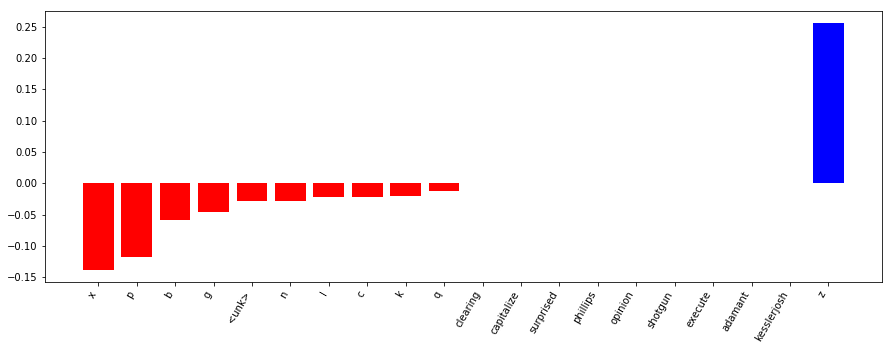

In [51]:
plot_coefficients(grid, vocab_unigram.ids_to_words)

In [30]:
np.sum(data['Diff_from_PrevWkAvg'].isnull())

1055

In [25]:
np.sort(grid.best_estimator_.coef_)[:15]

array([-0.16340655, -0.1050531 , -0.06928679, -0.05709225, -0.05422032,
       -0.04269192, -0.0295842 , -0.02804763, -0.01886292, -0.0011945 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

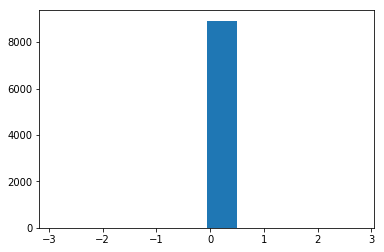

In [244]:
plt.hist(grid7.best_estimator_.coef_)
plt.show()

In [289]:
testSVM = LinearSVR(max_iter=5000)

In [309]:
testSVM.fit(encoded_unigram_orig_sparse, data['Diff_from_WkAvg'])

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=5000,
     random_state=None, tol=0.0001, verbose=0)

In [310]:
np.sort(testSVM.coef_)[:10]

array([-0.11378177, -0.10640752, -0.08572515, -0.04835733, -0.03798772,
       -0.00898215, -0.00114254,  0.        ,  0.        ,  0.        ])

In [269]:
np.sum(encoded_bigram_sparse.toarray()[0])

257

In [ ]:
pd.DataFrame(encoded_unigram_sparse.toarray()).to_excel('../data/encoded_unigram_sparse.xlsx', index=False)